In [5]:
import pandas as pd, numpy as np, scanpy as sc
import re
import sys
sys.path.append("/Users/rohan/public_html/Hegemon")
import HegemonUtil as hu

In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

First, we can convert the data stored in Hegemon into Scanpy's readable format AnnData.

In [7]:
expressionData = pd.read_csv("./GSE115978-GPL18573-expr.txt", sep='\t')

In [8]:
expressionData.pop("ProbeID")
genes = expressionData.pop("Name")
cellIDs = expressionData.columns.tolist()
adata = sc.AnnData(expressionData.T) 
adata

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 7186 × 23686

The data is already normalized using log2(1+TPM).

Then, we can add more metadata for each cell.

In [9]:
adata.obs['arr'] = np.array(cellIDs)
adata.var['genes'] = np.array(genes)

In [10]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "M1"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
print("Loaded hegemon object")

df = pd.read_csv(h.getSurv(), sep="\t")
print("Read surv file")
df.index = df.iloc[:,0]
for k in df.columns:
    k1 = re.sub("^c ", "", k)
    k1 = re.sub("^n ", "", k1)
    k1 = re.sub(" \(ch1\)", "", k1)
    val = [df[k][i] if i in df.index else '' for i in adata.obs['arr']]
    adata.obs[k1] = val
    print("read", k1)

Loaded hegemon object
Read surv file
read ArrayId
read time
read status
read title
read source_name
read organism
read taxid
read tumor-of-origin
read treatment-group
read cohort
read cell type
read molecule


In [11]:
adata

AnnData object with n_obs × n_vars = 7186 × 23686
    obs: 'arr', 'ArrayId', 'time', 'status', 'title', 'source_name', 'organism', 'taxid', 'tumor-of-origin', 'treatment-group', 'cohort', 'cell type', 'molecule'
    var: 'genes'

In [12]:
adata.var_names = adata.var["genes"]
adata.obs_names = adata.obs["arr"]

In [13]:
adata.raw = adata

We can now do more preprocessing and analysis of the data.
This shows the highly expressed genes.

normalizing counts per cell
    finished (0:00:00)


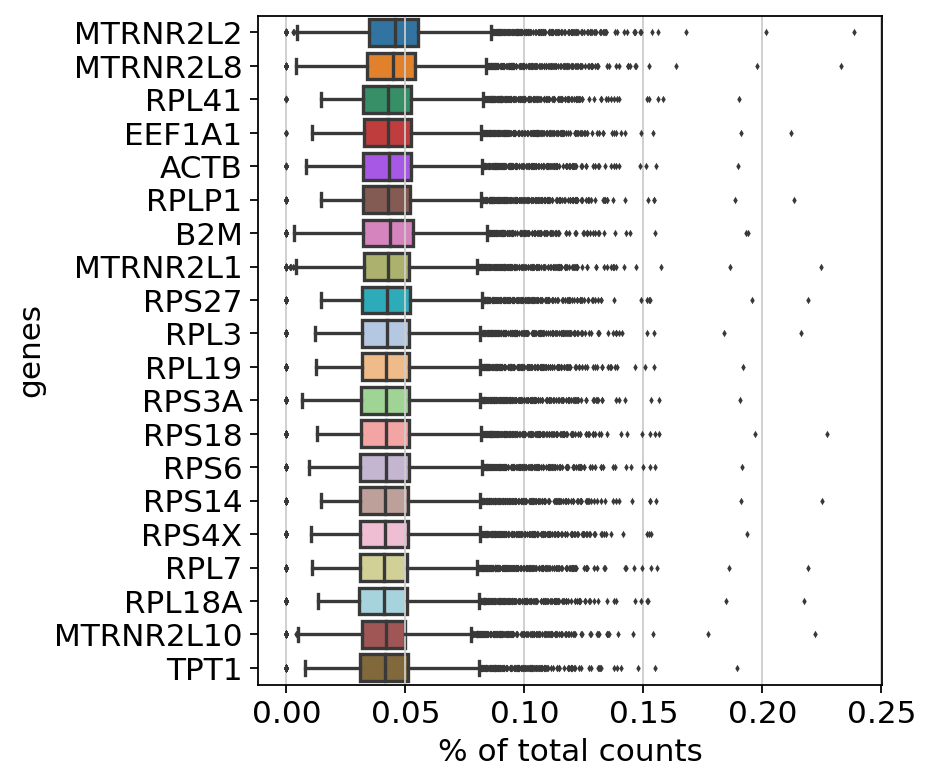

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20, )

We can also compute some quality control metrics such as the number of genes expressed in the count matrix,
the total counts per cell and the percentage of counts in mitochondrial genes.

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'source_name' as categorical
... storing 'organism' as categorical
... storing 'tumor-of-origin' as categorical
... storing 'treatment-group' as categorical
... storing 'cohort' as categorical
... storing 'cell type' as categorical
... storing 'molecule' as categorical


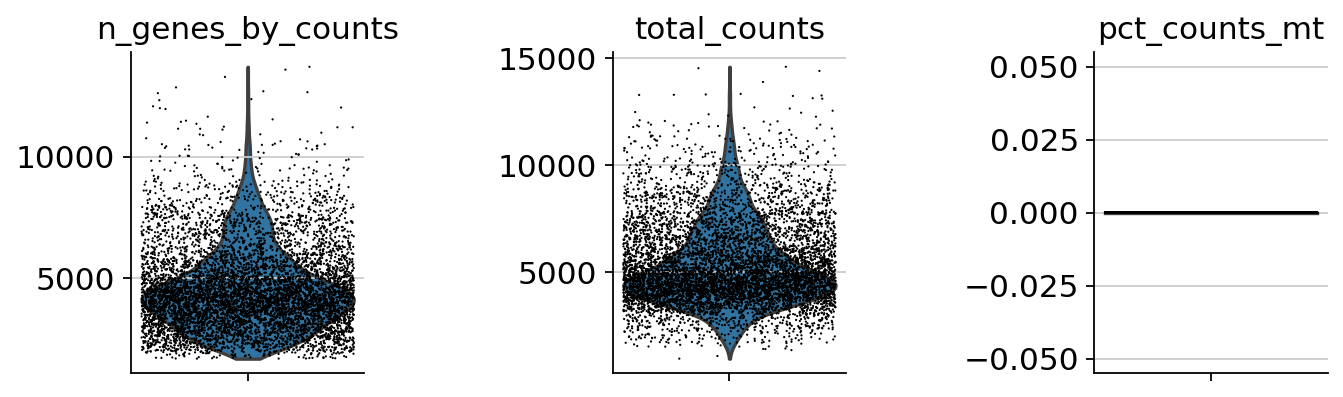

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


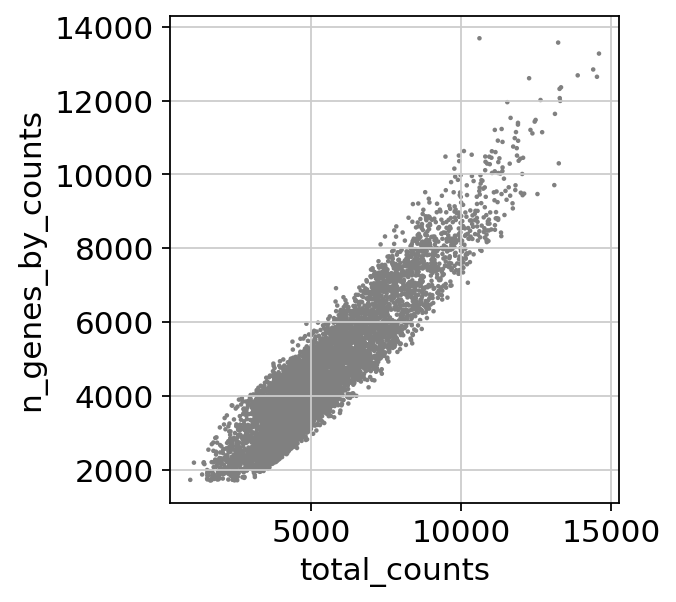

In [17]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

We can also remove genes that are expressed in very few cells.

In [29]:
sc.pp.filter_genes(adata, min_cells=10, inplace=True)

filtered out 2096 genes that are detected in less than 10 cells


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


We can identify highly variable genes in the dataset.

In [30]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [50]:
sc.pp.highly_variable_genes(adata, n_top_genes=501)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [51]:
var_genes = adata.var['highly_variable']
var_genes = var_genes.loc[lambda x:x].index.tolist()
len(var_genes)

500

We can look at markers of macrophages across cell types.

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


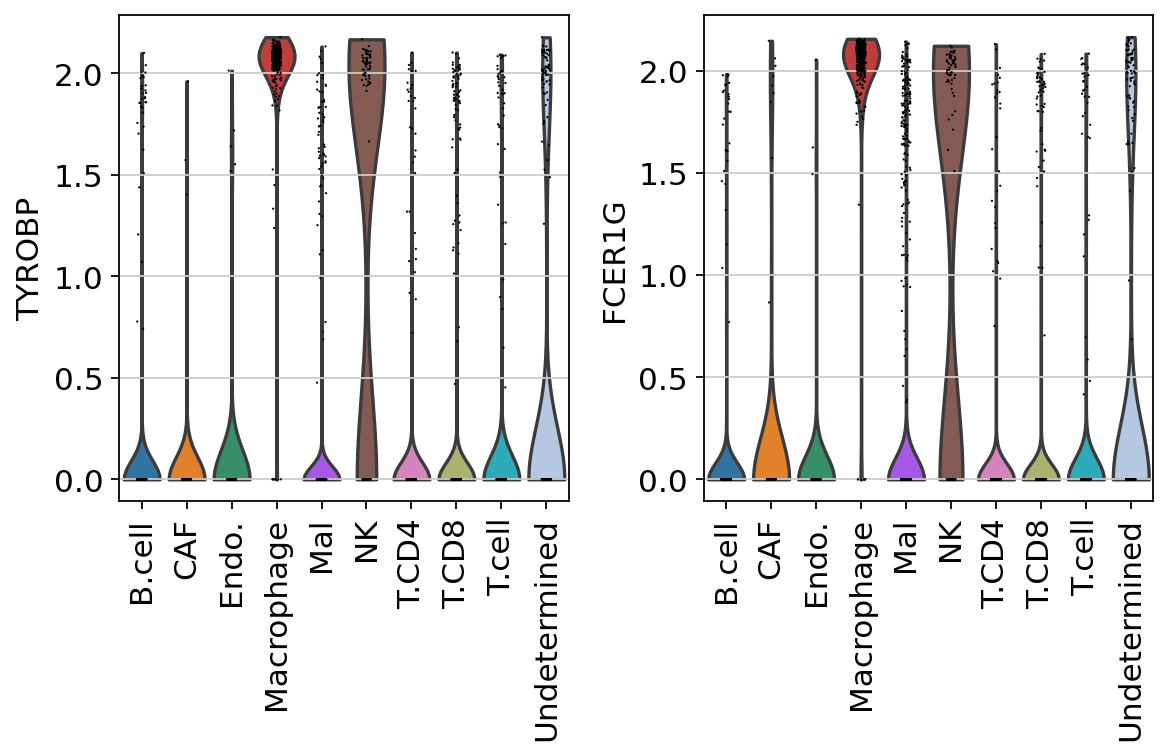

In [33]:
sc.pl.violin(adata, ["TYROBP", "FCER1G"], groupby="cell type", rotation=90)

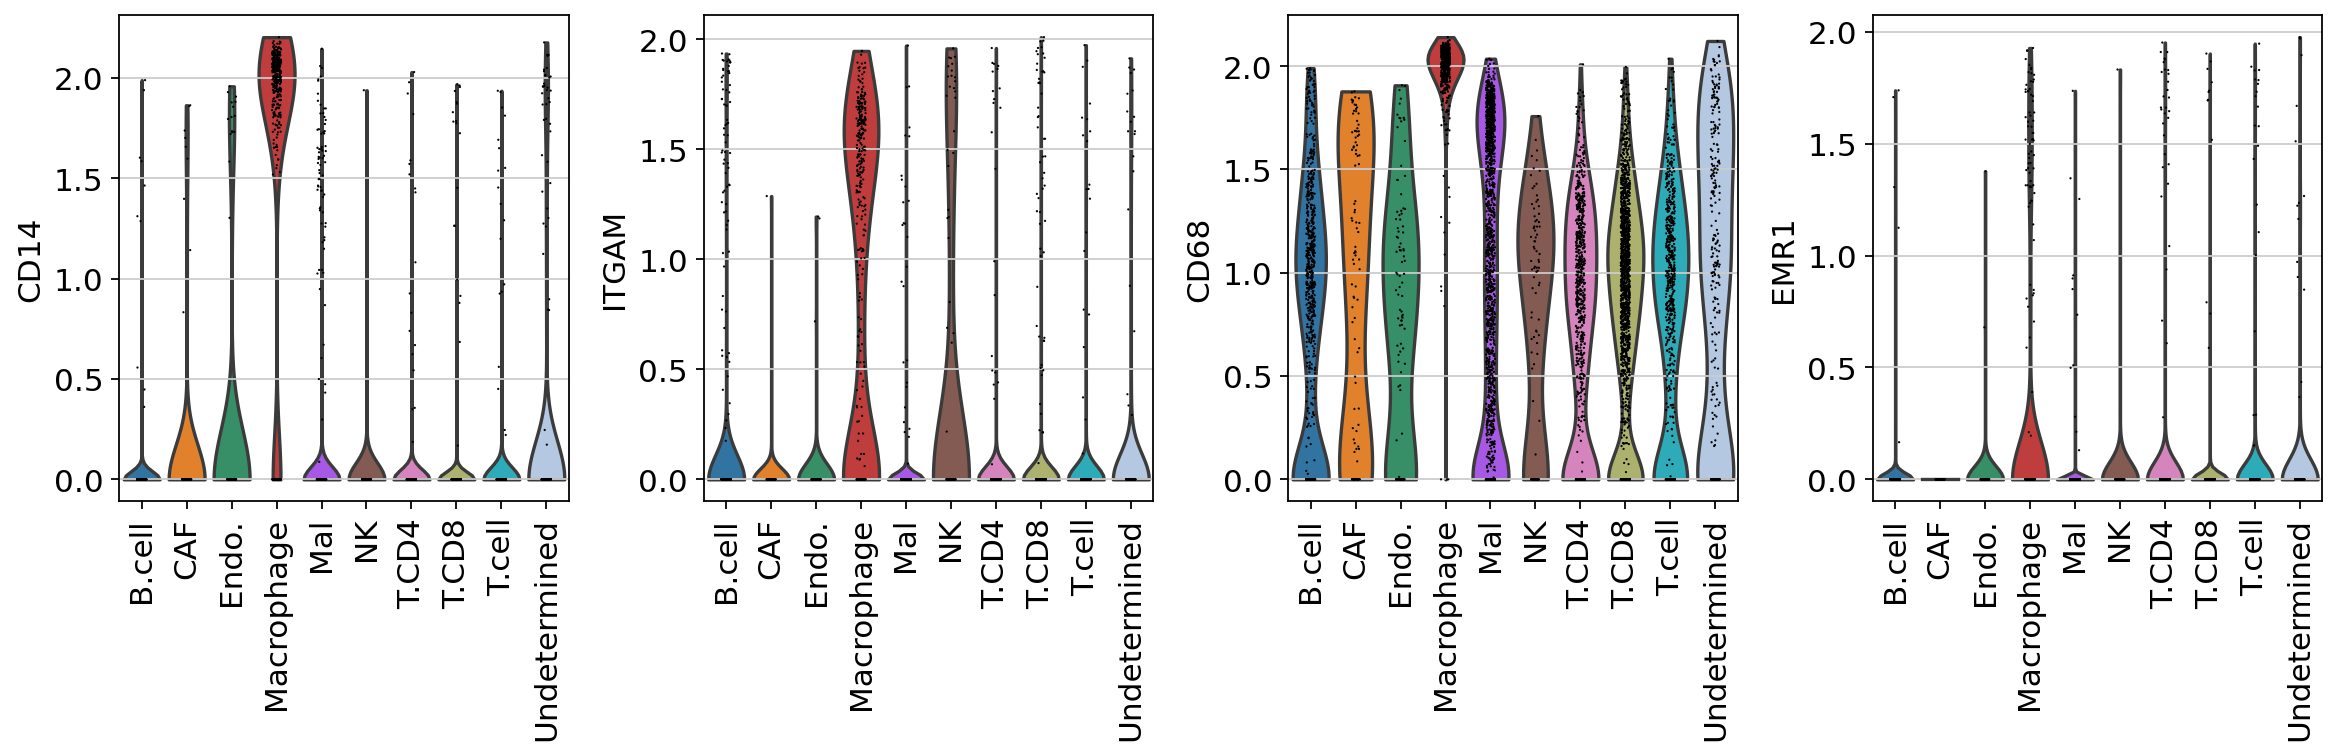

In [34]:
sc.pl.violin(adata, ["CD14", "ITGAM", "CD68", "EMR1"], groupby="cell type", rotation=90)

We can do differential expression analysis using the Wilcoxon rank-sum test.

ranking genes


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


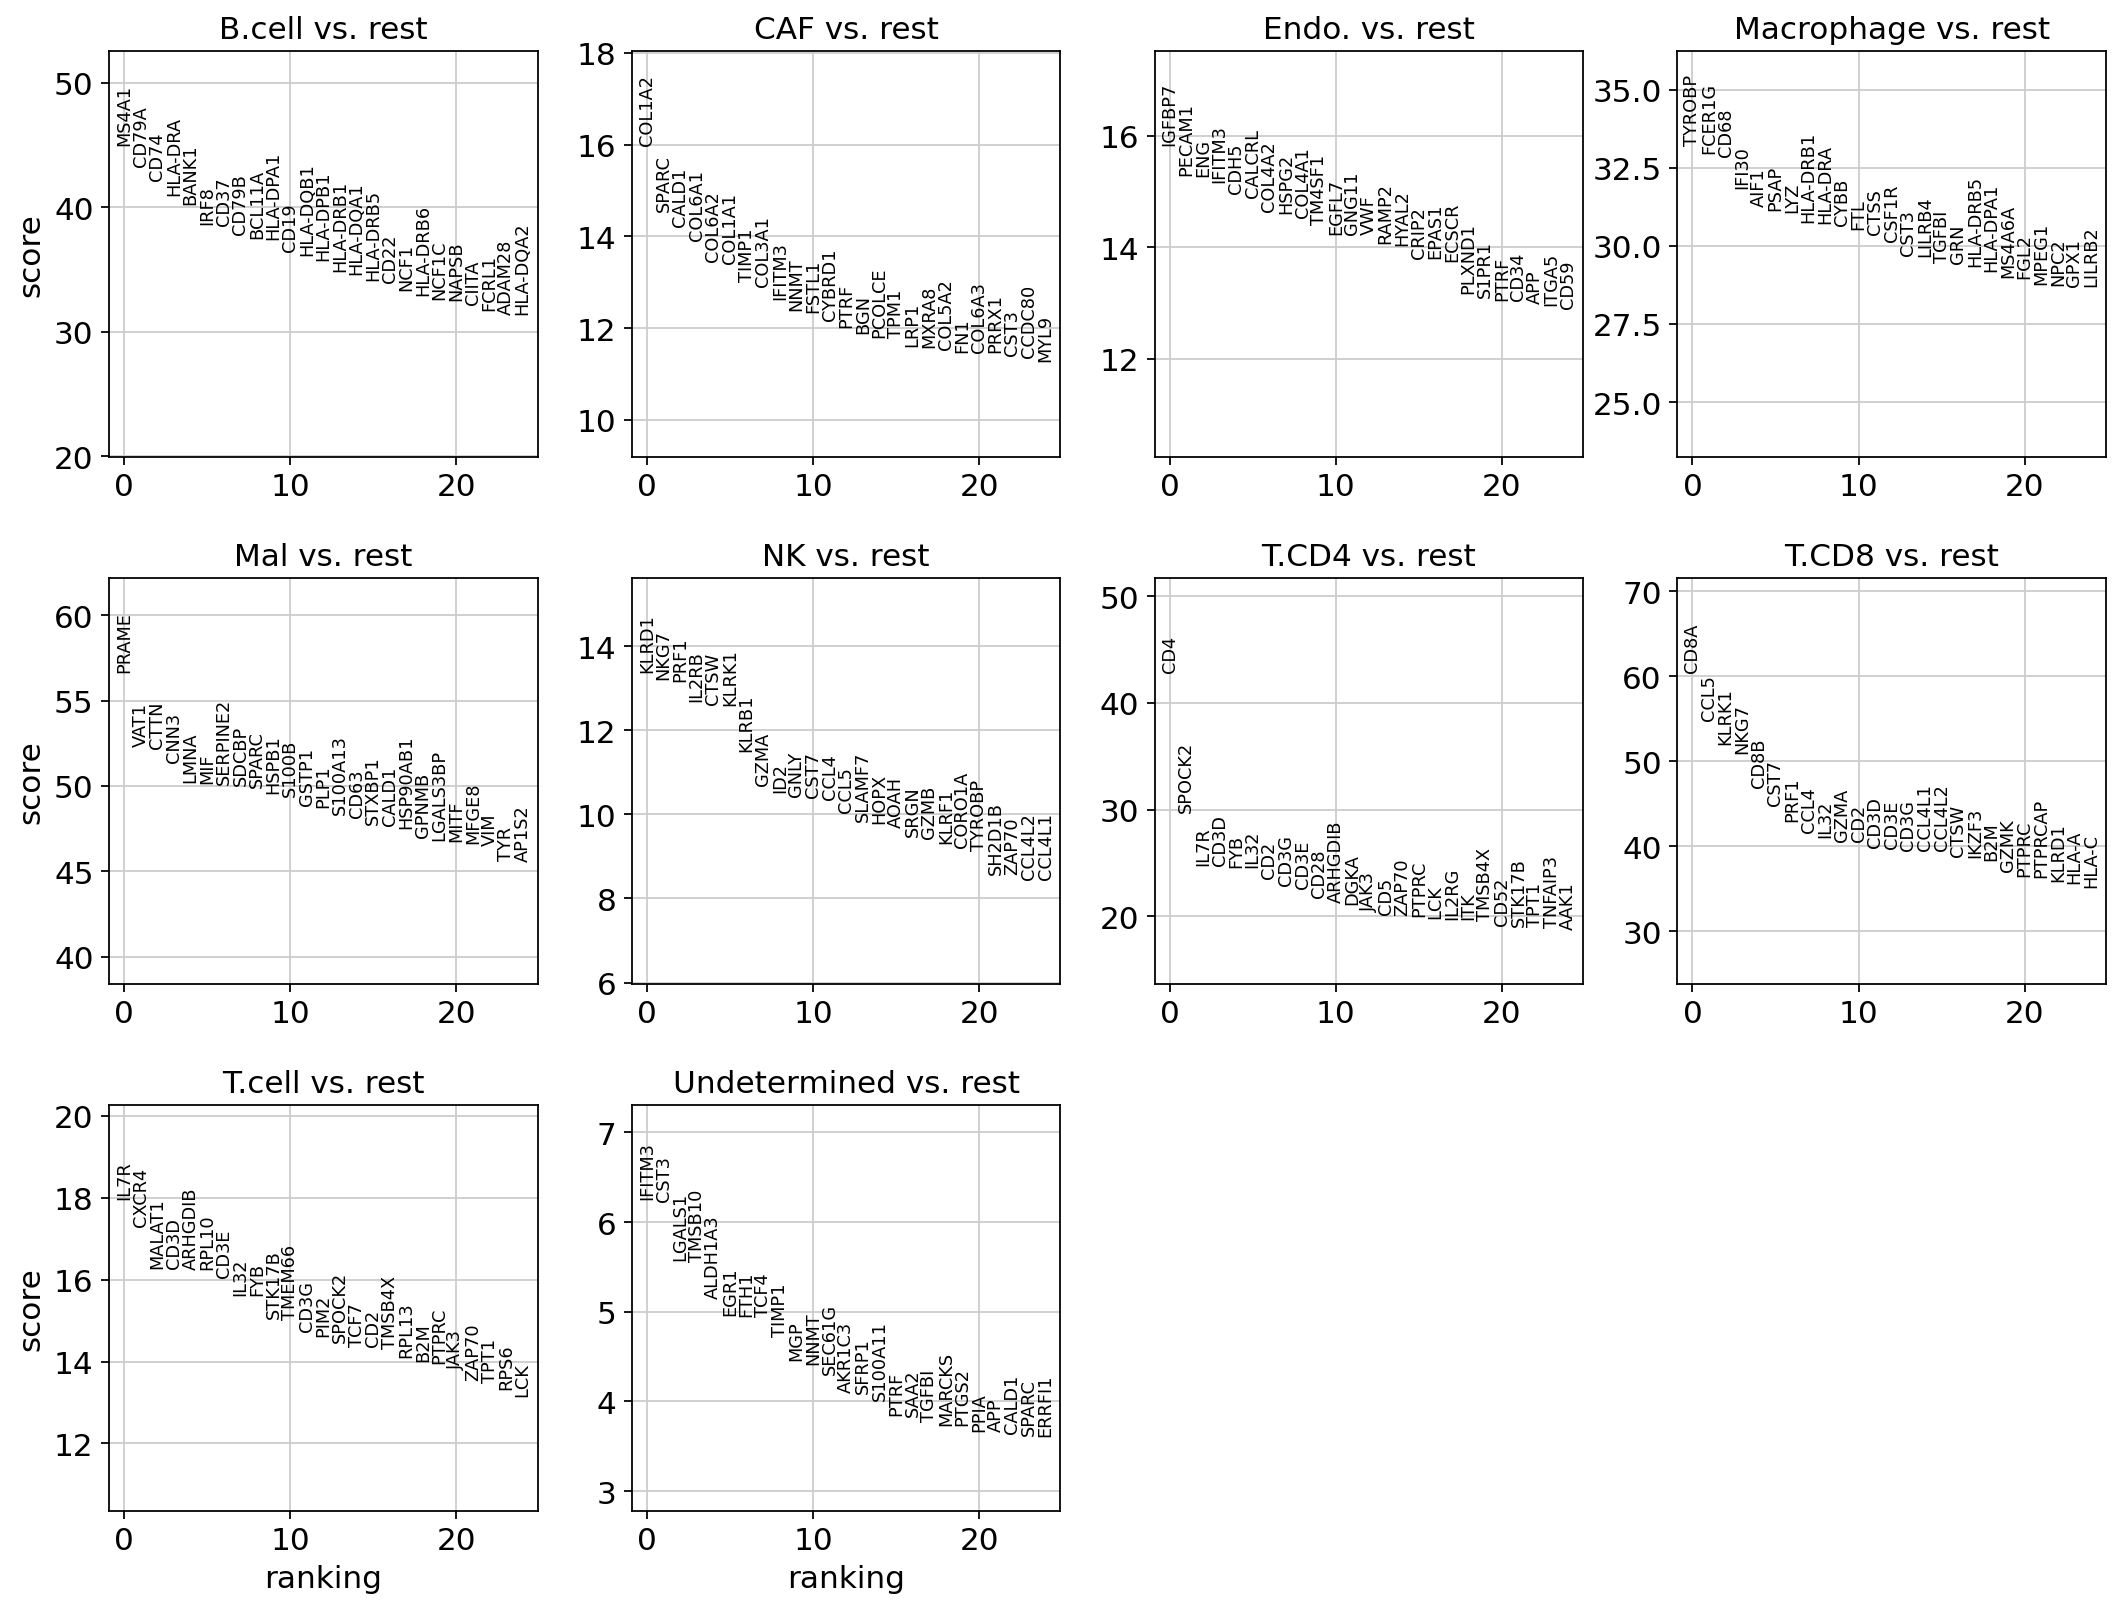

In [65]:
sc.tl.rank_genes_groups(adata, 'cell type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

In [73]:
results = adata.uns["wilcoxon"]
del results['params']
DEG = pd.DataFrame()
for i in list(results.keys()):
    DEG[i] = results[i]["Macrophage"]
DEG.sort_values(by="scores", axis=0, ascending=False)

,scores,names,logfoldchanges,pvals,pvals_adj
0,33.229225,TYROBP,5.955228,4.074581e-242,9.651053e-238
1,32.960880,FCER1G,5.650526,2.954740e-238,3.499299e-234
2,32.878708,CD68,2.287472,4.430068e-237,3.497687e-233
3,31.860146,IFI30,3.852359,9.524755e-223,5.640084e-219
4,31.260736,AIF1,5.648250,1.595561e-214,7.558490e-211
...,...,...,...,...,...
95,23.385822,TNFAIP2,4.234229,5.957831e-121,1.469971e-118
96,23.368515,SLC31A2,4.526694,8.935528e-121,2.181927e-118
97,23.333380,LRP1,3.196564,2.032757e-120,4.913050e-118
98,23.280575,SYK,2.681909,6.975473e-120,1.668900e-117


We can also rank using logistic regression.

ranking genes


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['logreg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:01:02)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


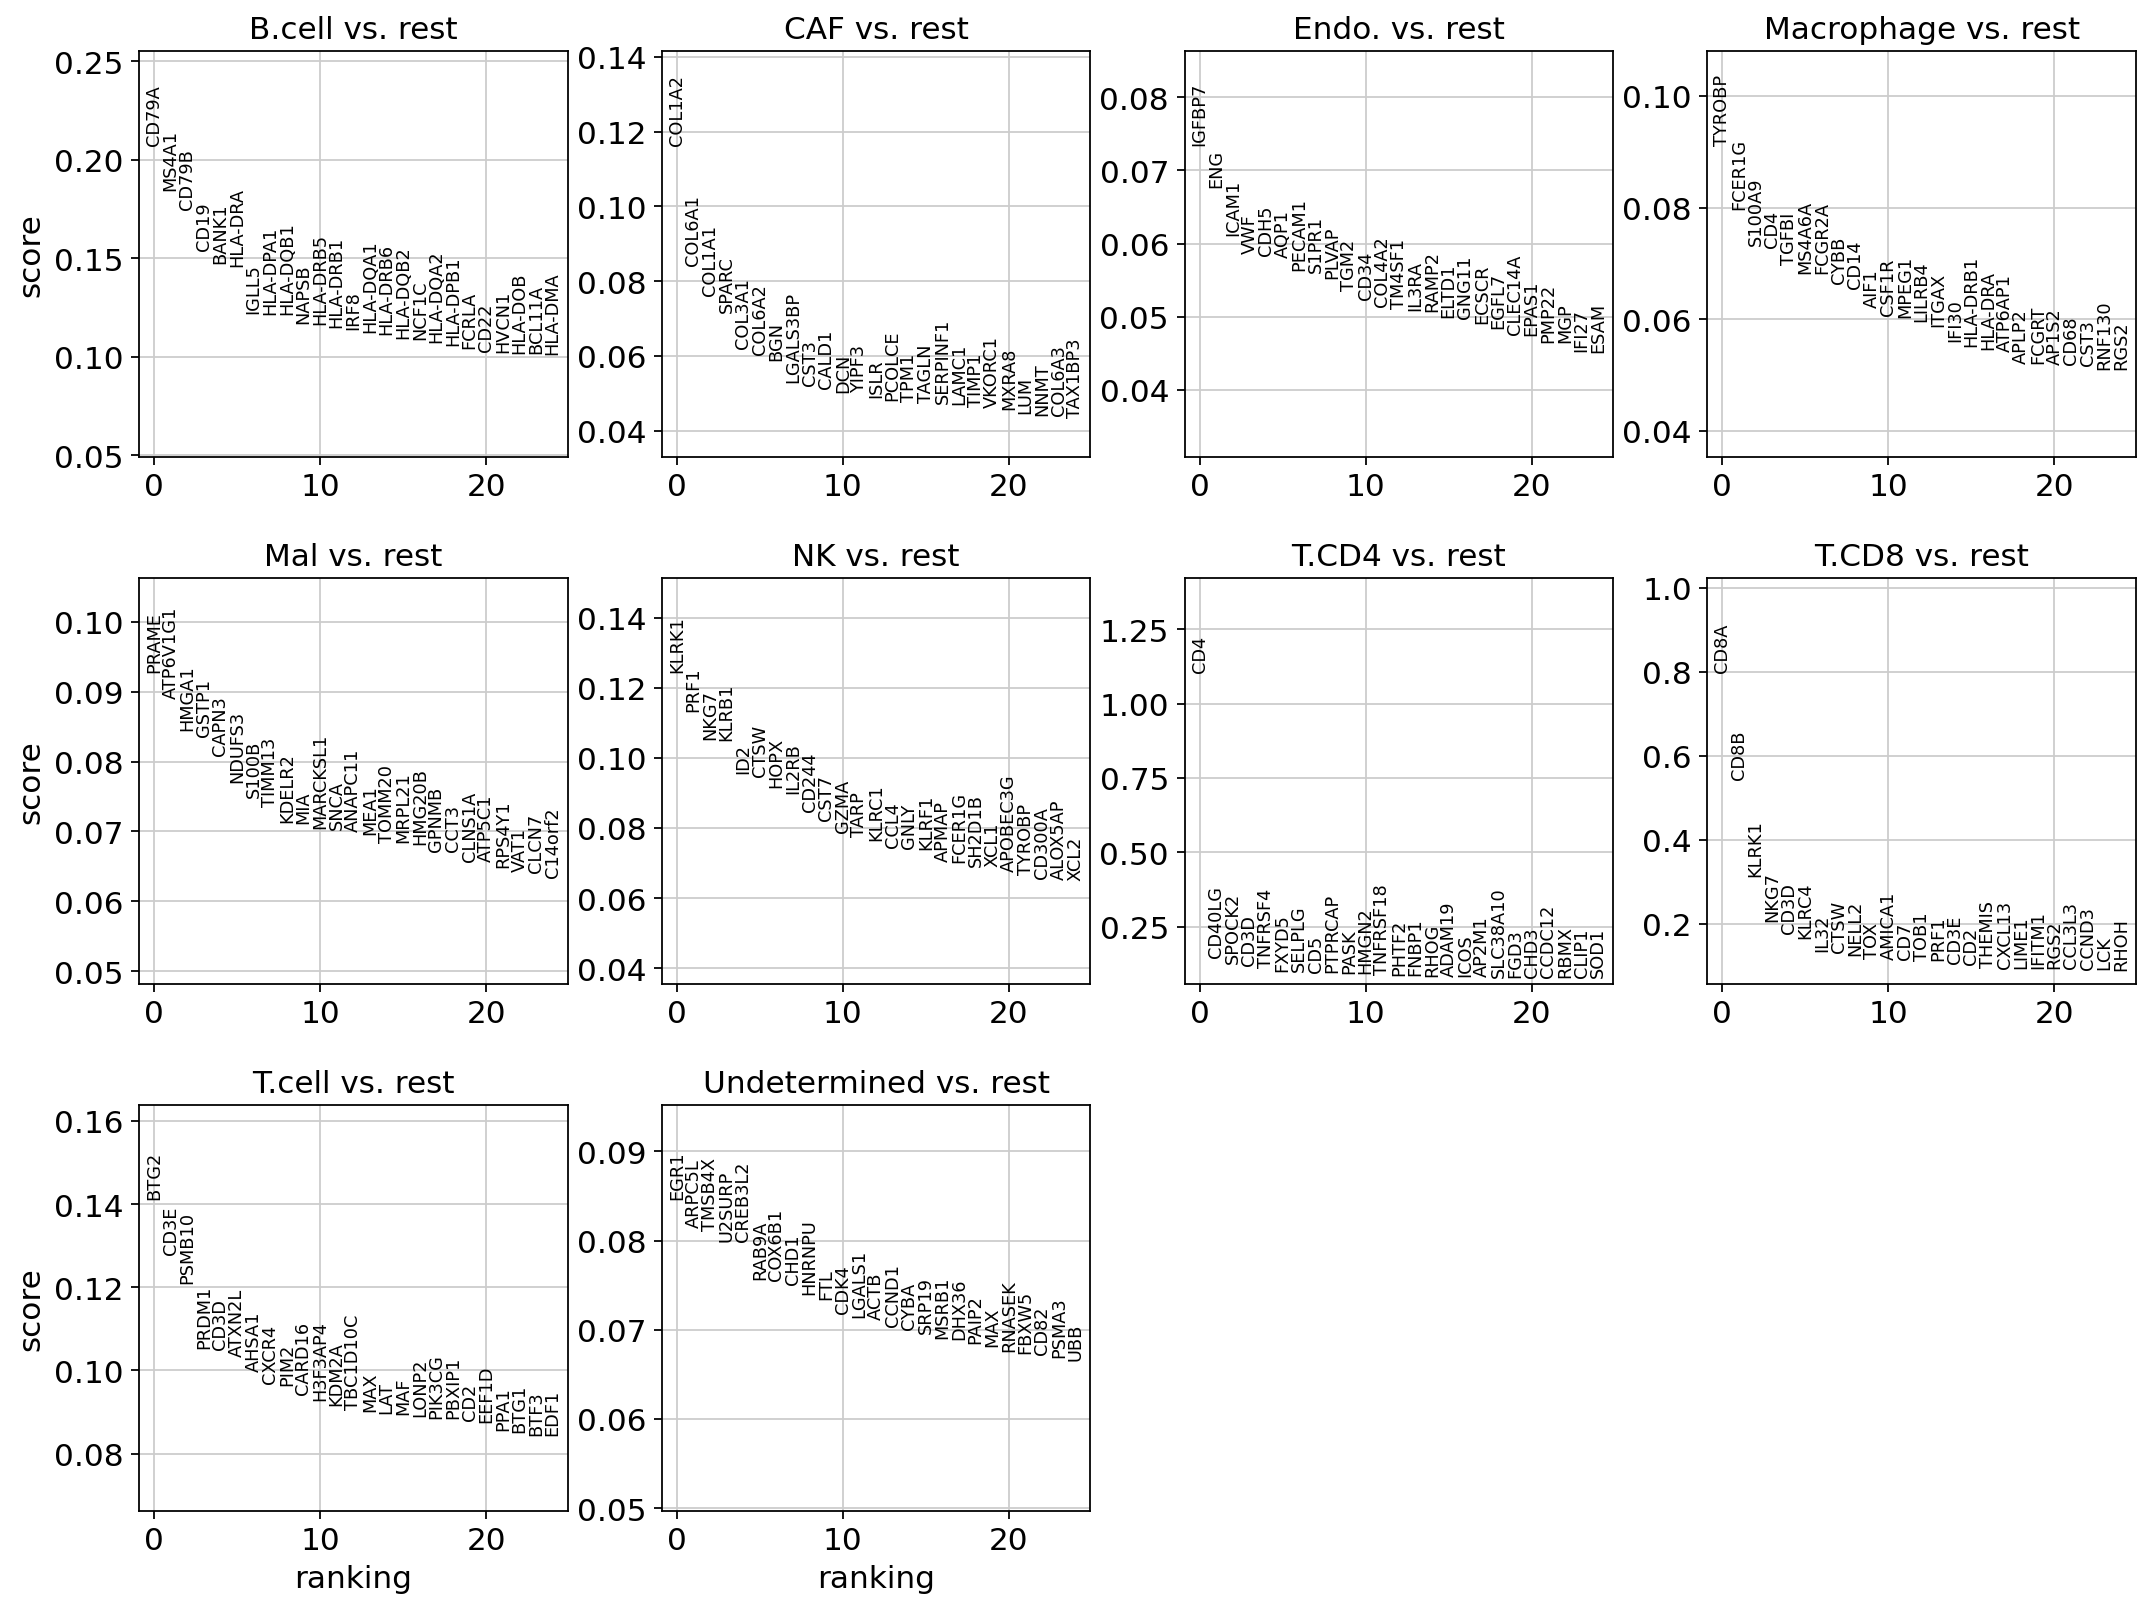

In [37]:
sc.tl.rank_genes_groups(adata, 'cell type', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

Exporting data

In [47]:
normExpressionValues = pd.DataFrame(adata.X)
normExpressionValues.columns = adata.var_names.tolist()
normExpressionValues.insert(0, "cellType", adata.obs['cell type'].tolist())
normExpressionValues.insert(0, "cellID", adata.obs_names.tolist())
normExpressionValues

,cellID,cellType,C9orf152,RPS11,ELMO2,CREB3L1,PNMA1,MMP2,TMEM216,TRAF3IP2-AS1,...,MIR4691,GPLD1,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
0,GSM3197115,Mal,0.0,2.067933,1.517847,0.0,1.686722,1.168448,1.526162,0.493304,...,0.000000,0.367588,1.496530,0.0,0.000000,0.966075,1.876721,1.638426,1.512449,0.0
1,GSM3197116,Mal,0.0,1.922102,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.802701,1.909713,0.000000,0.000000,0.000000,0.0
2,GSM3197117,Mal,0.0,2.015497,0.841959,0.0,0.695306,0.000000,0.000000,1.446632,...,0.000000,1.127459,0.000000,0.0,0.000000,0.000000,1.882266,1.141858,1.459023,0.0
3,GSM3197118,Mal,0.0,1.930309,1.691069,0.0,1.592092,0.000000,0.000000,1.038573,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.947145,1.666798,1.047136,0.0
4,GSM3197119,Mal,0.0,2.058619,1.509809,0.0,1.748345,1.676507,1.527963,0.757932,...,0.000000,0.624097,1.686261,0.0,1.601311,1.379246,1.924609,1.715210,1.352315,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,GSM3204296,T.CD8,0.0,1.924485,0.000000,0.0,0.000000,0.000000,0.000000,0.917210,...,0.000000,0.617210,1.937055,0.0,0.000000,0.000000,1.986266,0.000000,1.991558,0.0
7182,GSM3204297,T.CD8,0.0,1.977320,0.000000,0.0,0.000000,0.000000,0.000000,1.606071,...,0.000000,0.636619,0.000000,0.0,1.941190,1.212302,0.000000,0.000000,1.324604,0.0
7183,GSM3204298,T.CD8,0.0,1.986248,0.000000,0.0,0.000000,0.000000,0.000000,1.255850,...,0.000000,0.868394,0.000000,0.0,1.997277,0.000000,0.000000,0.000000,1.601028,0.0
7184,GSM3204299,T.CD8,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.398943,...,1.868568,1.488624,0.000000,0.0,0.000000,0.000000,1.668218,0.000000,1.948110,0.0


In [48]:
normExpressionValues.to_pickle("./MLData/GSE115978-allData.pkl")

In [60]:
with open('./MLData/variable_genes.txt', 'w') as f:
    for item in var_genes:
        f.write("%s\n" % item)
    print('Done')

Done


In [75]:
DEG.to_pickle("./MLData/diffexpr.pkl")

In [ ]:
adata.write_h5ad('./MLData/scanpy_DGE_macrophage.h5ad')